# Gabor Transform to Identify Notes in Live Music
### Authors: Grace Flynn, Jack Kovach and Max Huber

Follow the outline in this notebook to upload live music files (designed primarily for Guitar), and identify its frequency content! The frequency content is then compared to a library of frequency information for individual notes in order to identify the best matches.

The Gabor transform is quite similar to a STFT, it is used to isolate individual notes from the rest of a given song. It is used as a type of sliding window, where it passes a short period of information in the time domain, which is then Fourier Transformed to identify the relevent frequencies which make up a given note or chord. The points to isolate with the Gabor transform are identified using numpy's find peaks method to isolate spikes in amplitude indicating a new note has been played. This is done across the entire span of the song, with the end result being outputted as 'sheet music'. 

Inspiration was taken from the website https://mojan.ca/blogs/computational-mathematics/fourier-transforms-for-writing-sheet-music, but the code we have written here is all our own.

In [1]:
# Imports
!pip install audio2numpy
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
import audio2numpy as a2n
from IPython.display import clear_output
import time
plt.rcParams["figure.figsize"] = (10,5)

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Download pre-recorded individual notes to use as a basis for comparison. Adds each note to the dictionary lib_notes, along with its arg_max frequency. Numpy's argmax function is used to identify the frequency value corresponding to the maximial amplitude in the frequency domain, eg. the dominant frequency in in the recording for each note. 

Note: A, frequency: 111.58 Hz
Note: B, frequency: 125.3 Hz
Note: D, frequency: 147.45 Hz
Note: E, frequency: 167.07 Hz
Note: G, frequency: 199.34 Hz


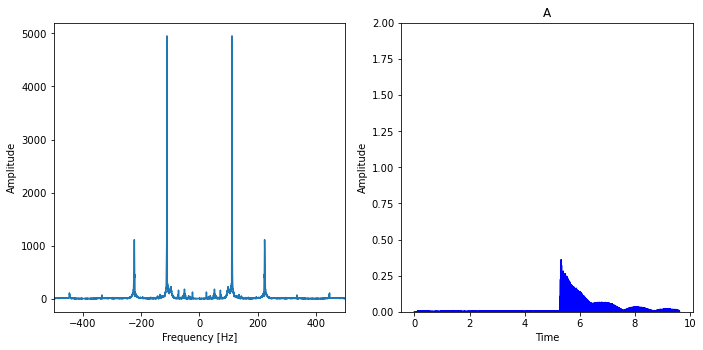

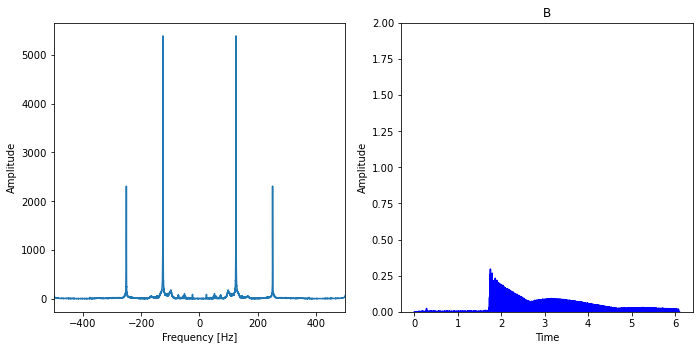

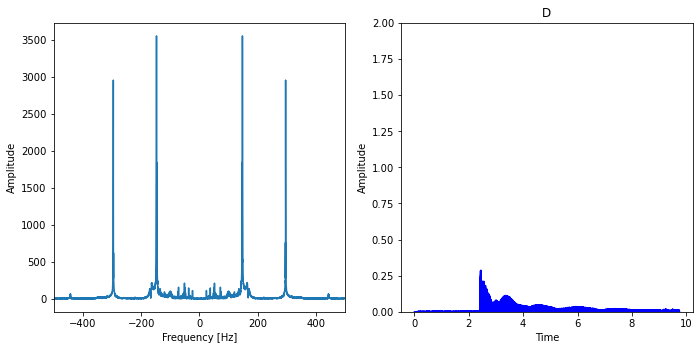

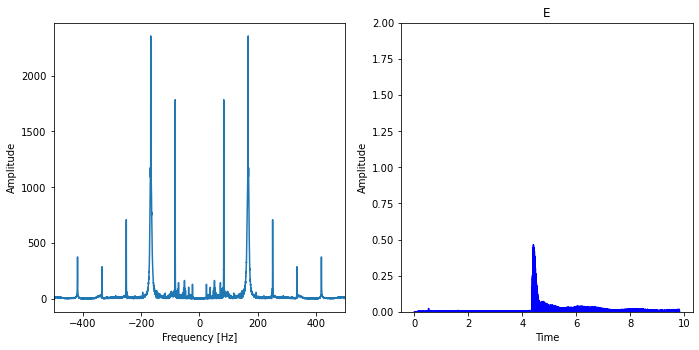

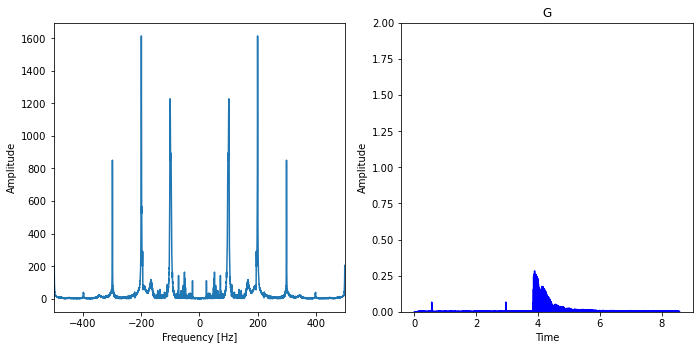

In [2]:
library_notes = ['A', 'B', 'D', 'E', 'G']
lib_notes = {}

# loop through the names of the notes, note files should be in the same folder as the script and named A.mp3, B.mp3, etc. 
for i in library_notes:

  # uses audio2numpy library to transform mp3 audio file into numpy array with sampling frequency fs
  curr_note, fs = a2n.open_audio('{}.mp3'.format(i))
  ft_hn = np.fft.fftshift(np.fft.fft(curr_note)) #takes the fast FT of the mp3 file and centers the zero frequency component
  t=np.arange(0, len(curr_note)/fs,1/fs)
  
  # based on integer rounding in declaring the length of t we ran into some issues with the length of the t
  # array matching the length of the curr_note array, so this loop modifies t to be the same length as curr_note
  while len(t) != len(curr_note):
    if len(curr_note) > len(t):
      t = np.append(t, [t[-1] + (1/fs)])
    else:
      t = t[:len(t)-1]


  freq=np.linspace(-fs/2, fs/2, len(curr_note))

  # identify the key frequency in curr_note, and store it in the lib_note dictionary such that A: 111 Hz, B: 125 Hz, etc. 
  frequency_id = round(abs(freq[abs(ft_hn).argmax()]), 2)
  print ("Note: {}, frequency: {} Hz".format(i, frequency_id))
  lib_notes[i] = frequency_id

  # for each identified note, display the time-domain and frequency domain information
  fig,axs = plt.subplots(1, 2)
  fig.tight_layout(pad=2.5)
  axs[0].set_xlabel("Frequency [Hz]")
  axs[0].set_ylabel("Amplitude")
  axs[0].set_xlim([-500, 500])
  axs[0].plot(freq, abs(ft_hn))
    
  axs[1].plot(t, curr_note, 'b')
  axs[1].set_ylim([0, 2])
  axs[1].set_ylabel('Amplitude')
  axs[1].set_xlabel('Time')
  axs[1].set_title('{}'.format(i))



Taken from discussion worksheet 5, this peak_count function is used to identify the
peaks as defined by some threshold value. We take the top 2% amplitude elements in the datset, and sum them to create an average height across all spikes. That sum is then multiplied by a threshold parameter, with a spike being counted if it is >= the amplitude of the average height of a spike multiplied by the treshold parameter.

In [3]:
# taken from DW 5!
def peak_count(t, data, thresh):
    # t and data are same size, thresh is threshold % of maximum
    # need to isolate first spike to use as our correlation function
    dt = t[1]-t[0]
    max_value = np.average(np.sort(data)[-1*int(len(data)/50):]) # average of all spikes
    tspike = []
    indices = []
    count = 0

    i = 0
    while i < len(data):
        if data[i] > max_value * thresh:
            count += 1
            tspike.append(i)
            indices.append(max_value)
            i += 15000 # so spikes can't be counted more than once
        else:
            i += 1
    return [count, tspike, indices]


Here we implement the peak_counts method to determine the number of peaks in the new music files. The music files we downloaded are two bars from a song, 'Bananna Pancakes', as played by Jack Kovach. These two bars will be condensed into a single array, and then the peaks will be counted and a plot will be produced to analyze the fit of the peaks.

15


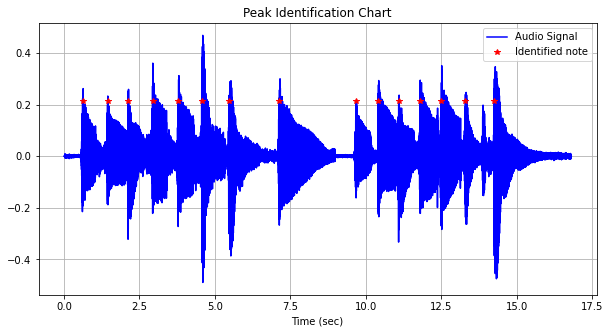

In [4]:
audio_signal1, fs = a2n.open_audio('Bar1.mp3')
audio_signal2, fs = a2n.open_audio('Bar2.mp3')

# Append the bars together to create a single song
condensed_signal=np.append(audio_signal1, audio_signal2) 
t=np.arange(0,len(condensed_signal)/fs,1/fs)
t=t[0:len(condensed_signal)]


# Find peaks, we use a high threshold here to increase specificity of the peaks which were chosen.
# this would change depending on the song, and how distinct the notes are from the background noise
count, t_peak, peak_indices = peak_count(t, condensed_signal, 0.95)
print (count)

# Plots the raw time series data from the song, as well as red starts at each identified peak
fig,axs = plt.subplots(1, 1)
axs.plot(t, condensed_signal,'b-',label='Audio Signal')
axs.set(xlabel='Time (sec)', title= 'Peak Identification Chart')
axs.grid(True)
for iter_val in range(0, len(t_peak)):
  if iter_val == 0:
    axs.plot(t_peak[iter_val]*(t[1]-t[0]), peak_indices[iter_val],'r*', label='Identified note') #Plots a red star on graph for spike
  else:
    axs.plot(t_peak[iter_val]*(t[1]-t[0]), peak_indices[iter_val],'r*') # Only need 1 label

axs.legend(loc='best')

# results will hold the argmax frequency information for each identified note
results = []
notes = (np.array(t_peak)+1000)*(t[1]-t[0]) # right shift the notes since the peak occurs at the beginning of each one!
freq=np.linspace(-fs/2, fs/2, len(condensed_signal))

Next, loop through the identified peaks using the corresponding indices stored in the ndarray 'notes' to produce 3 graphs for each peak: the Gaussian windowing function overlaying the condensed audio signal in the time domain, the product of the Gaussian filter with the condensed audio signal (filtered_note) in the time domain, and the magnitude of the fast fourier transform shifted so that its centered at freq=0 (ft_hn) to determine the frequency content of the peaks and ensure that the windowing function is capturing the peaks correctly.

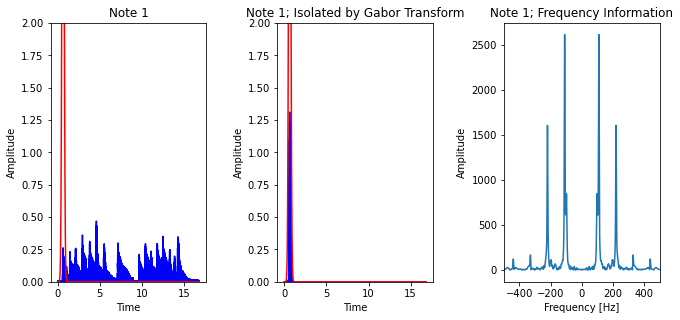

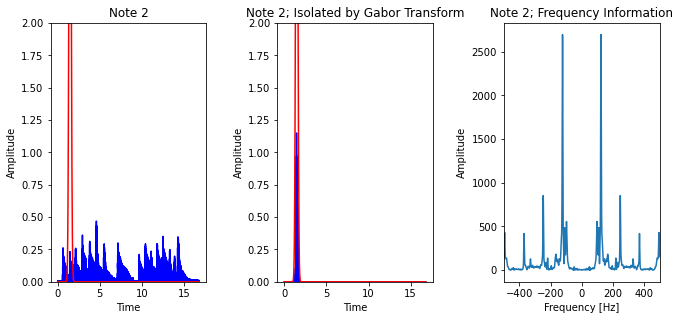

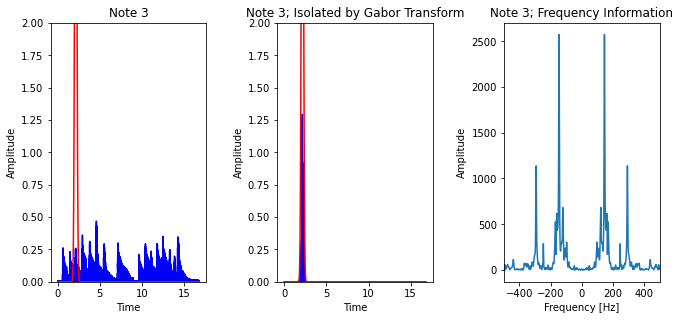

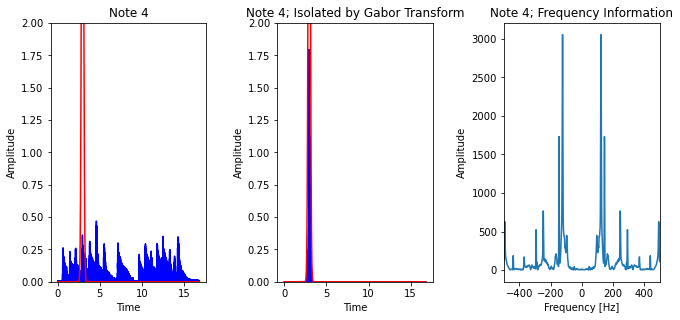

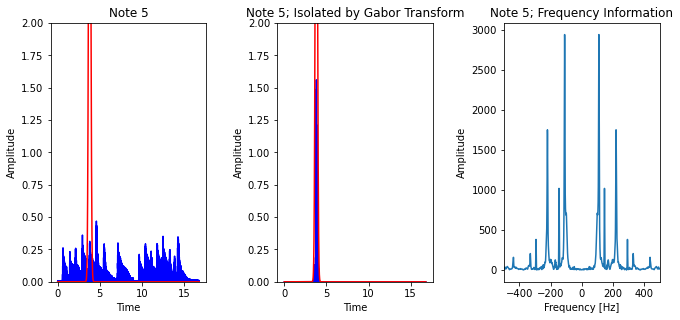

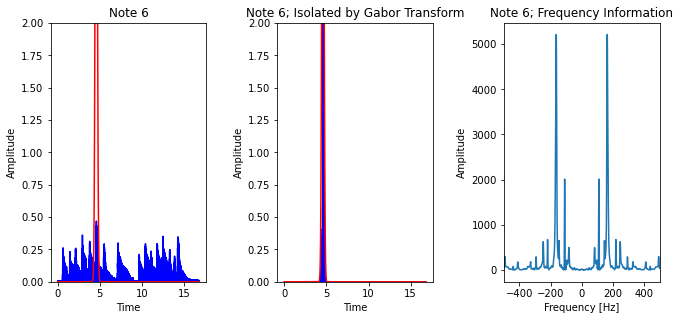

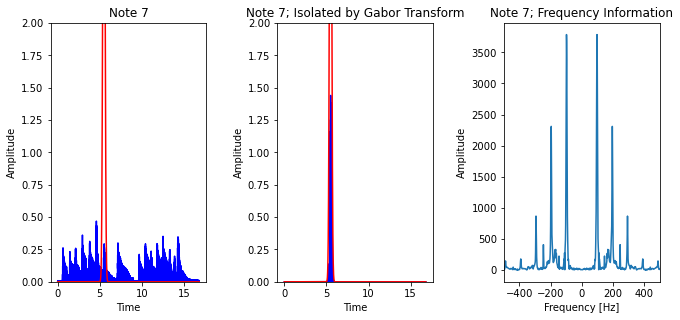

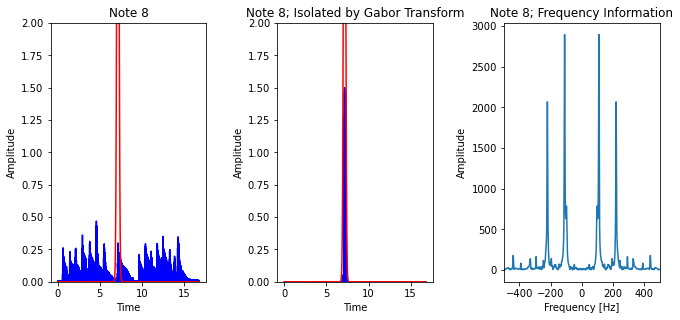

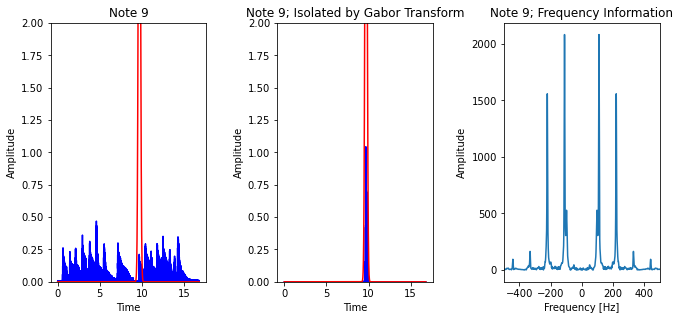

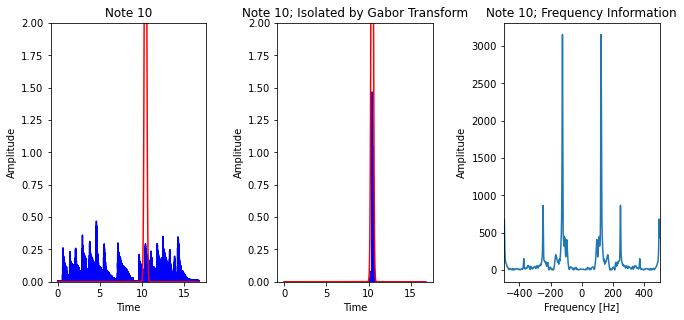

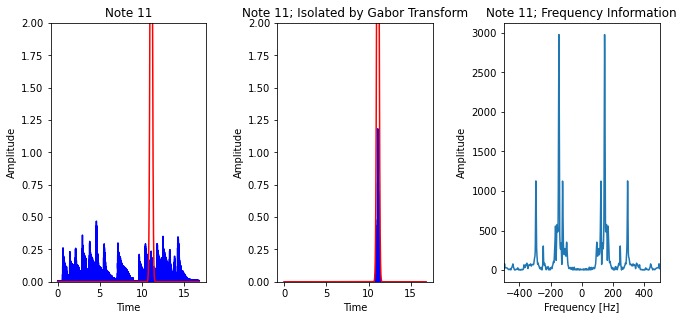

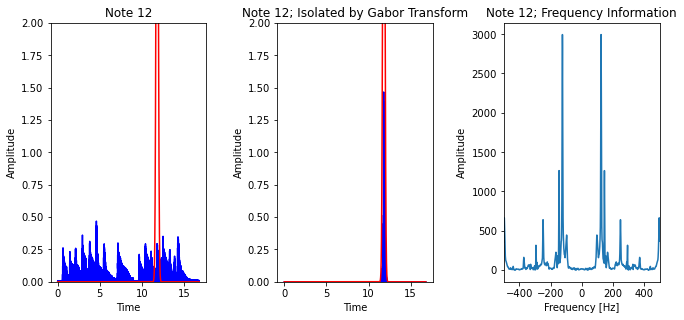

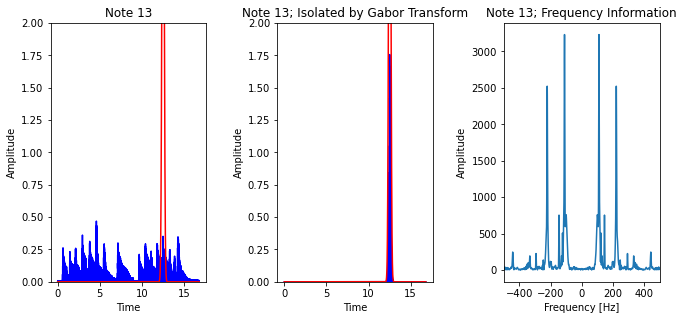

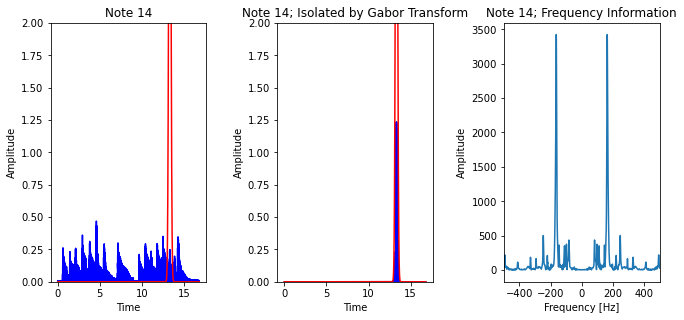

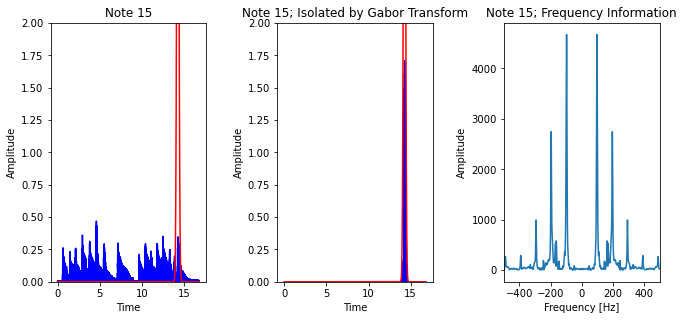

In [5]:
count = 1
for i in notes:
    fft_filter = 5*np.exp(-35*np.power(t - i, 2)) # gaussian filter designed to isolate individual notes (the individual parameters were chosen \
    # in a manner which fit the underlying data of guitar music the best)
    filtered_note = fft_filter*condensed_signal # multiply gaussian by audio signal to zero all other notes in the song!
    ft_hn = np.fft.fftshift(np.fft.fft(filtered_note)) #take the fast fourier transform of the filtered note and shift it so its centered at zero
    results.append(ft_hn)
    
    #plot len(notes) rows with 3 graphs per row depicting the step by step results of the calculations above
    fig,axs = plt.subplots(1, 3)
    fig.tight_layout(pad=4)
    axs[2].set_xlabel("Frequency [Hz]")
    axs[2].set_ylabel("Amplitude")
    axs[2].set_title('Note {}; Frequency Information'.format(count))
    axs[2].set_xlim([-500, 500])
    axs[2].plot(freq, abs(ft_hn))

    axs[1].plot(t, filtered_note, 'b')
    axs[1].plot(t, fft_filter, 'r')
    axs[1].set_ylim([0, 2])
    axs[1].set_ylabel('Amplitude')
    axs[1].set_xlabel('Time')
    axs[1].set_title('Note {}; Isolated by Gabor Transform'.format(count))
    
    axs[0].plot(t, condensed_signal, 'b')
    axs[0].plot(t, fft_filter, 'r')
    axs[0].set_ylim([0, 2])
    axs[0].set_ylabel('Amplitude')
    axs[0].set_xlabel('Time')
    axs[0].set_title('Note {}'.format(count))
    count += 1

From the gaussian filtering and fast fourier transform above, compare the max frequency of the isolated peak or note to the frequencies stored in the pre-recorded library of notes to determine the nearest match (most_likely_note) and print the frequency, associated note, and the time in seconds at which it is played.  

In [6]:
ordered_notes_list = []
#iterate through the frequency data windowed around each peak 
for iter in range(len(results)):
    frequency = abs(freq[results[iter].argmax()]) #returns the absolute value of the max frequency from the FFT of the window
    track_diff = {}
    #nested for loop stores the difference between the max freq found above and the prerecorded frequencies in 'lib_notes' in the dictionary 'track_diff'
    for i in lib_notes.keys():
      diff = abs(frequency - lib_notes[i])
      track_diff[diff] = i
    
    td_keys = list(track_diff) #creates a list of the frequency value differences associated with each note
    min_diff = min(list(td_keys)) #find the minimum difference
    most_likely_note = track_diff[min_diff] #indexes the dictionary 'track_diff' to find the note associated with the minimum difference
    print(round(frequency,2), ": ", most_likely_note, " played at {} seconds".format(notes[iter])) #print results
    ordered_notes_list.append(most_likely_note) #creates a list of strings containing the most likely note played at each peak

print (ordered_notes_list)

110.09 :  A  played at 0.6388125 seconds
123.3 :  B  played at 1.4732916666666667 seconds
146.22 :  D  played at 2.147145833333333 seconds
123.66 :  B  played at 2.9552916666666667 seconds
110.09 :  A  played at 3.8012916666666667 seconds
164.02 :  E  played at 4.5823125 seconds
99.2 :  A  played at 5.490583333333333 seconds
110.09 :  A  played at 7.150791666666667 seconds
110.45 :  A  played at 9.702375 seconds
123.78 :  B  played at 10.429708333333332 seconds
147.35 :  D  played at 11.107312499999999 seconds
123.96 :  B  played at 11.812166666666666 seconds
110.33 :  A  played at 12.514229166666667 seconds
163.84 :  E  played at 13.316729166666667 seconds
97.47 :  A  played at 14.264479166666666 seconds
['A', 'B', 'D', 'B', 'A', 'E', 'A', 'A', 'A', 'B', 'D', 'B', 'A', 'E', 'A']


Finally, create sheet music depicting the identity and order of the detected notes by graphing 5 horizontal lines to replicate an actual octave and display the notes played with quarter note symbols at their appropriate locations.

(0.0, 7.0)

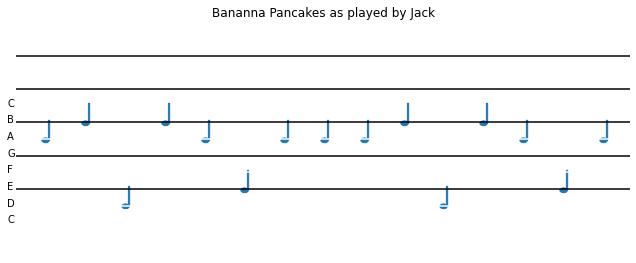

In [7]:
#creates dictionary of arbitrary values corresponding to the height of the horizontal line
dict = {"G":3.25,"A":3.75,"B":4.25,"C":1.25,"D":1.75,"E":2.25,"F":2.75}


#creates an evenly spaced array for the position along the x axis of the notes
xspacing = np.linspace(1,len(ordered_notes_list)+1,len(ordered_notes_list))

#indexes the dictionary created above with the identified notes to determine the arbitrary height at which each should be plotted
vals=[]
for i in ordered_notes_list:
  vals.append(dict[i])

plt.figure(figsize=(9, 4))
plt.scatter(xspacing, vals, s=500, marker='$♩$') #enlarge marker size and make the marker a quarter note symbol
plt.axhline(1, color='white', label='C')
plt.axhline(1.5, color='white', label='D')
plt.axhline(2, color='black', label="E")
plt.axhline(2.5,color='white',label='F')
plt.axhline(3, color='black', label='G')
plt.axhline(3.5, color='white', label='A')
plt.axhline(4, color='black', label='B')
plt.axhline(5, color='black')
plt.axhline(6, color='black')

plt.text(0, 1, 'C')
plt.text(0, 1.5, 'D')
plt.text(0, 2, 'E')
plt.text(0, 2.5, 'F')
plt.text(0, 3, 'G')
plt.text(0, 3.5, 'A')
plt.text(0, 4, 'B')
plt.text(0,4.5,'C')

plt.title("Bananna Pancakes as played by Jack")
plt.tight_layout()
plt.axis('off')
plt.ylim([0,7])